# CBMC SCML analysis

In [1]:
from sc_spectrum.scml import rbf_neighbor_graph
from sc_spectrum.scml import sparse_spectral
from sc_spectrum.scml import scml
from sc_spectrum.scml import spectral_clustering

from sc_spectrum.cbmc.cbmc_preprocessing import preprocess_rna, preprocess_adt

from sc_spectrum.visualization import umap_embed, umap_scatter, recolor_clusters

/home/groups/song/songlab2/jacobrl3/sc-spectrum/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from time import asctime, localtime

import numpy as np

import pandas as pd

import scipy
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

from sklearn.metrics import silhouette_score
from sklearn.metrics import normalized_mutual_info_score

import torch

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import seaborn as sns

plt.style.use('default')
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

In [3]:
use_gpu = True

if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


### Load the Seurat WNN results

In [4]:
input_dir = "../../sc-spectrum-datasets/"

seurat_umap = pd.read_csv(input_dir + "seurat_v4_cbmc_reduc_wnn_human.umap.csv", header=0, index_col=0)
seurat_meta = pd.read_csv(input_dir + "seurat_v4_cbmc_meta_human.csv", index_col=0)

### Load and preprocess the UMI count data

In [5]:
n_clust = len(np.unique(seurat_meta["wsnn_res.0.2"]))
print("Number of clusters = {}".format(n_clust))


cbmc_rna_count = pd.read_csv(input_dir + "GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv",
                             header = 0, index_col = 0)

cbmc_rna_hm_pca = preprocess_rna(input_dir + "GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv", n_pc = 30, random_state = 12345678)

human_cells = list(cbmc_rna_hm_pca.index)

cbmc_adt_count = pd.read_csv(input_dir + "GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv",
                             header = 0, index_col = 0).loc[:, cbmc_rna_hm_pca.index]

cbmc_adt_clr = preprocess_adt(input_dir + "GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv", human_cells = human_cells)


Number of clusters = 12


Text(0.5, 1.0, 'CBMC Seurat WNN (res = 0.2) clustering 12 clusters')

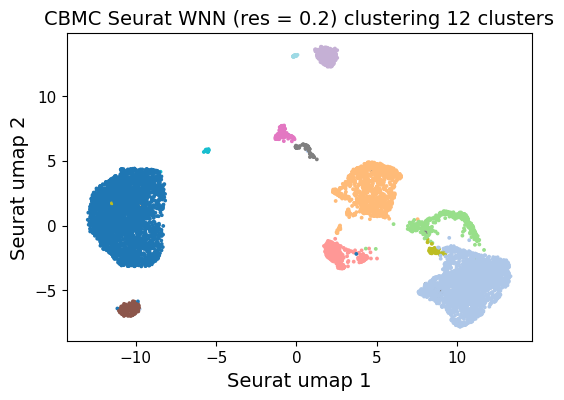

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

plt.scatter(seurat_umap.loc[human_cells].values[:,0],
            seurat_umap.loc[human_cells].values[:,1],
            c = seurat_meta.loc[human_cells]["wsnn_res.0.2"],
            cmap = cm.tab20, s = 3)

ax.set_xlabel("Seurat umap 1", fontsize=14)
ax.set_ylabel("Seurat umap 2", fontsize=14)
ax.set_title("CBMC Seurat WNN (res = 0.2) clustering {} clusters".format(len(np.unique(seurat_meta["wsnn_res.0.2"]))), fontsize=14)

In [7]:
D_adt = squareform(pdist(cbmc_adt_clr.values.astype(np.float32), metric = "euclidean"))
D_rna = squareform(pdist(cbmc_rna_hm_pca.values.astype(np.float32), metric = "euclidean"))

### RNA spectral clustering

In [8]:
Gs_rna = rbf_neighbor_graph(cbmc_rna_hm_pca.values.astype(np.float32), adaptive = True)

L_rna, w_rna, v_rna = sparse_spectral(Gs_rna, n_clust = 30)

cl_rna = spectral_clustering(v_rna, n_clust = n_clust)

Text(0.5, 1.0, 'CBMC RNA pca Euclidean dist local\nrbf clustering 12 clusters (device = cuda)')

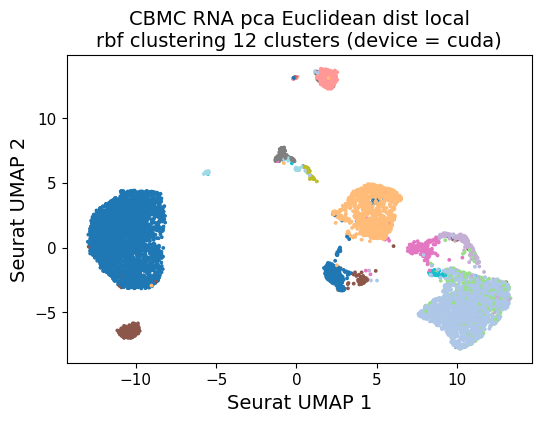

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

plt.scatter(seurat_umap.loc[human_cells].values[:,0],
            seurat_umap.loc[human_cells].values[:,1],
            c = cl_rna, cmap = cm.tab20, s = 3)

ax.set_xlabel("Seurat UMAP 1", fontsize=14)
ax.set_ylabel("Seurat UMAP 2", fontsize=14)
ax.set_title("CBMC RNA pca Euclidean dist local\nrbf clustering {} clusters (device = {})".format(n_clust, device), fontsize=14)


In [10]:
print("Full RNA Euclidean RNA = {}".format(silhouette_score(D_rna, cl_rna, metric = "precomputed")))
print("Full ADT Euclidean RNA = {}".format(silhouette_score(D_adt, cl_rna, metric = "precomputed")))

print("Full RNA Euclidean Seurat WNN = {}".format(silhouette_score(D_rna, seurat_meta["wsnn_res.0.2"][human_cells], metric = "precomputed")))
print("Full ADT Euclidean Seurat WNN = {}".format(silhouette_score(D_adt, seurat_meta["wsnn_res.0.2"][human_cells], metric = "precomputed")))

Full RNA Euclidean RNA = 0.3696853991036063
Full ADT Euclidean RNA = 0.2496958004134172
Full RNA Euclidean Seurat WNN = 0.24065752804118104
Full ADT Euclidean Seurat WNN = 0.3977267723355348


### ADT spectral clutsering

In [11]:
Gs_adt = rbf_neighbor_graph(cbmc_adt_clr.values.astype(np.float32), adaptive = True)

L_adt, w_adt, v_adt = sparse_spectral(Gs_adt, n_clust = 30)

cl_adt = spectral_clustering(v_adt, n_clust = n_clust)

Text(0.5, 1.0, 'CBMC ADT clr Euclidean dist local\nrbf clustering 12 clusters (device = cuda)')

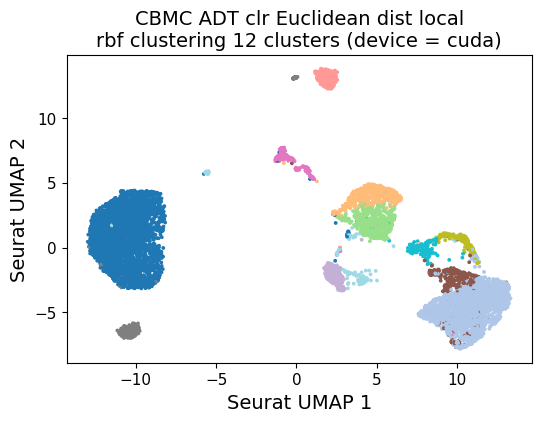

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

plt.scatter(seurat_umap.loc[human_cells].values[:,0],
            seurat_umap.loc[human_cells].values[:,1],
            c = cl_adt, cmap = cm.tab20, s = 3)

ax.set_xlabel("Seurat UMAP 1", fontsize=14)
ax.set_ylabel("Seurat UMAP 2", fontsize=14)
ax.set_title("CBMC ADT clr Euclidean dist local\nrbf clustering {} clusters (device = {})".format(n_clust, device), fontsize=14)


In [13]:
print("Full RNA Euclidean ADT = {}".format(silhouette_score(D_rna, cl_adt, metric = "precomputed")))
print("Full ADT Euclidean ADT = {}".format(silhouette_score(D_adt, cl_adt, metric = "precomputed")))

print("Full RNA Euclidean Seurat WNN = {}".format(silhouette_score(D_rna, seurat_meta["wsnn_res.0.2"][human_cells], metric = "precomputed")))
print("Full ADT Euclidean Seurat WNN = {}".format(silhouette_score(D_adt, seurat_meta["wsnn_res.0.2"][human_cells], metric = "precomputed")))

Full RNA Euclidean ADT = 0.08461876391234759
Full ADT Euclidean ADT = 0.3941304146422469
Full RNA Euclidean Seurat WNN = 0.24065752804118104
Full ADT Euclidean Seurat WNN = 0.3977267723355348


### SCML clustering

In [14]:
print("Start: {}".format(asctime(localtime())))
w_scml, v_scml, cbmc_scml_cls = scml([Gs_rna, Gs_adt], n_clust=n_clust, device=device, alpha=100.0)
print("End: {}".format(asctime(localtime())))

Start: Fri May 20 15:42:34 2022
End: Fri May 20 15:42:42 2022


Text(0.5, 1.0, 'CBMC SCML Euclidean dist local\nrbf clustering 12 clusters (device = cuda)($\\alpha = 100$)')

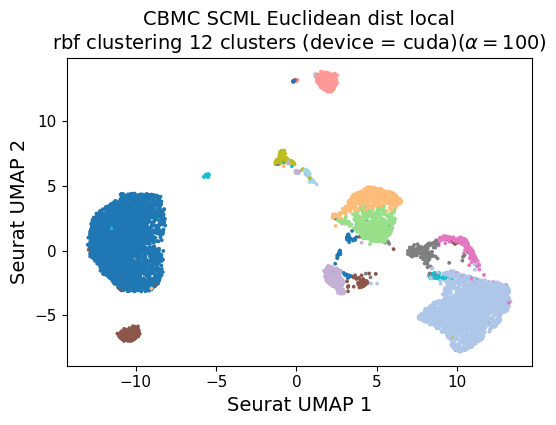

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

plt.scatter(seurat_umap.loc[human_cells].values[:,0],
            seurat_umap.loc[human_cells].values[:,1],
            c = cbmc_scml_cls, cmap = cm.tab20, s=3)

ax.set_xlabel("Seurat UMAP 1", fontsize=14)
ax.set_ylabel("Seurat UMAP 2", fontsize=14)
ax.set_title("CBMC SCML Euclidean dist local\nrbf clustering {} clusters (device = {})".format(n_clust, device) + r"($\alpha = 100$)", fontsize=14)


In [16]:
print("Full RNA Euclidean SCML = {}".format(silhouette_score(D_rna, cbmc_scml_cls, metric = "precomputed")))
print("Full ADT Euclidean SCML = {}".format(silhouette_score(D_adt, cbmc_scml_cls, metric = "precomputed")))

print("Full RNA Euclidean Seurat WNN = {}".format(silhouette_score(D_rna, seurat_meta["wsnn_res.0.2"][human_cells], metric = "precomputed")))
print("Full ADT Euclidean Seurat WNN = {}".format(silhouette_score(D_adt, seurat_meta["wsnn_res.0.2"][human_cells], metric = "precomputed")))

Full RNA Euclidean SCML = 0.2177251733523114
Full ADT Euclidean SCML = 0.4211400956285408
Full RNA Euclidean Seurat WNN = 0.24065752804118104
Full ADT Euclidean Seurat WNN = 0.3977267723355348


## NMI comparison of clustering

In [17]:
# Load the WLL clustering
cl_wll = pd.read_csv(input_dir + "CBMC_8005_WLL_12.csv", header = 0, index_col = 0)

print("RNA-WNN = {}".format(normalized_mutual_info_score(cl_rna, seurat_meta["wsnn_res.0.2"][human_cells])))
print("ADT-WNN = {}".format(normalized_mutual_info_score(cl_adt, seurat_meta["wsnn_res.0.2"][human_cells])))

print("RNA-WLL = {}".format(normalized_mutual_info_score(cl_rna, cl_wll["WLL_12"])))
print("ADT-WLL = {}".format(normalized_mutual_info_score(cl_adt, cl_wll["WLL_12"])))

print("RNA-SCML = {}".format(normalized_mutual_info_score(cl_rna, cbmc_scml_cls)))
print("ADT-SCML = {}".format(normalized_mutual_info_score(cl_adt, cbmc_scml_cls)))

print("RNA-ADT NMI = {}".format(normalized_mutual_info_score(cl_rna, cl_adt)))
print("WLL-WNN NMI = {}".format(normalized_mutual_info_score(cl_wll["WLL_12"], seurat_meta["wsnn_res.0.2"][human_cells])))
print("SCML-WNN NMI = {}".format(normalized_mutual_info_score(cbmc_scml_cls, seurat_meta["wsnn_res.0.2"][human_cells])))
print("SCML-WLL NMI = {}".format(normalized_mutual_info_score(cbmc_scml_cls, cl_wll["WLL_12"])))



RNA-WNN = 0.801923338387128
ADT-WNN = 0.8513769227152255
RNA-WLL = 0.8353946866175317
ADT-WLL = 0.8764357995900173
RNA-SCML = 0.836541356905639
ADT-SCML = 0.8812655335152556
RNA-ADT NMI = 0.7542256176750637
WLL-WNN NMI = 0.8789990174875865
SCML-WNN NMI = 0.8607991849324254
SCML-WLL NMI = 0.915074392026676


### 2D UMAP embedding of the SCML embedding

In [18]:
v_scml_norm = v_scml[:, :n_clust] / np.linalg.norm(v_scml[:, :n_clust], axis = 1, keepdims = True)

embedding = umap_embed(v_scml_norm, n_clust)

In [19]:
dict_idents = {0:'CD4+ T', 
               1:'CD14+ Mono', 
               2:'NK', 
               3:'CD16+', 
               4:'CD8+ T', 
               5:'B', 
               6:'T/Mono doublets', 
               7:'CD34+', 
               8:'Eryth', 
               9:'cDC', 
               10:'pDC',
               11:'CD19+CD3+'}

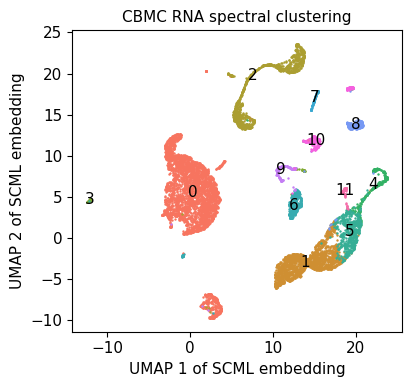

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             recolor_clusters(seurat_meta["wsnn_res.0.2"], cl_rna), legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC RNA spectral clustering", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/figure3a-rna-spectral-recolor.pdf", format="pdf", transparent=True)


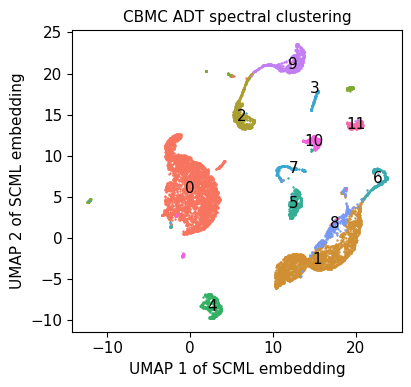

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             recolor_clusters(seurat_meta["wsnn_res.0.2"], cl_adt), legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC ADT spectral clustering", fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/figure3b-adt-spectral-recolor.pdf", format="pdf", transparent=True)


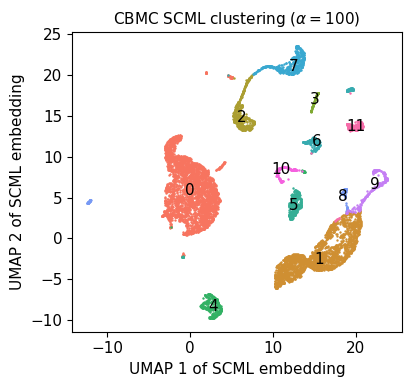

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             recolor_clusters(seurat_meta["wsnn_res.0.2"], cbmc_scml_cls), legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC SCML clustering " + r"($\alpha = 100$)", fontsize=11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/figure3c-scml-recolor.pdf", format="pdf", transparent=True)


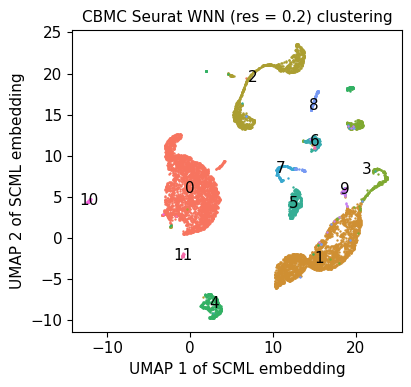

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             seurat_meta["wsnn_res.0.2"], legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC Seurat WNN (res = 0.2) clustering", fontsize=11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/figure3d-seurat-wnn-recolor.pdf", format="pdf", transparent=True)


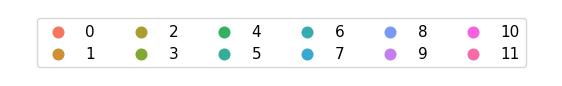

In [24]:
palette_0 = sns.husl_palette(n_colors=12, h=0.05, s=0.9, l=0.65)
palette_1 = sns.husl_palette(n_colors=12, h=0.05, s=0.9, l=0.75)
palette_2 = sns.husl_palette(n_colors=12, h=0.05, s=0.9, l=0.55)
colors = palette_0 + palette_1 + palette_2

scs = []
labels = np.unique(seurat_meta["wsnn_res.0.2"])
for i, label in enumerate(labels):
    barcodes = seurat_umap.index[ (np.where(seurat_meta["wsnn_res.0.2"] == label))[0] ]
    n_label = len(barcodes)
    rx = seurat_umap.loc[barcodes].iloc[:, 0]
    ry = seurat_umap.loc[barcodes].iloc[:, 1]
    scs.append(ax.scatter(rx, ry, s=3, linewidths=0, alpha=1, color=colors[i], label=f"Clus. {(label):d}: ({n_label:d} cells)"))
    ax.text(rx.median(), ry.median(), (label), ha='center', va='center')

fig, ax = plt.subplots(1, 1, figsize=(6, 1))

ax.axis(False)

leg = ax.legend(scs, list(range(n_clust)), loc = "center", ncol = 6, markerscale = 5)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/figure3-color-legend-recolor.pdf", format="pdf", transparent=True)

### Scatter plot with ADT signal

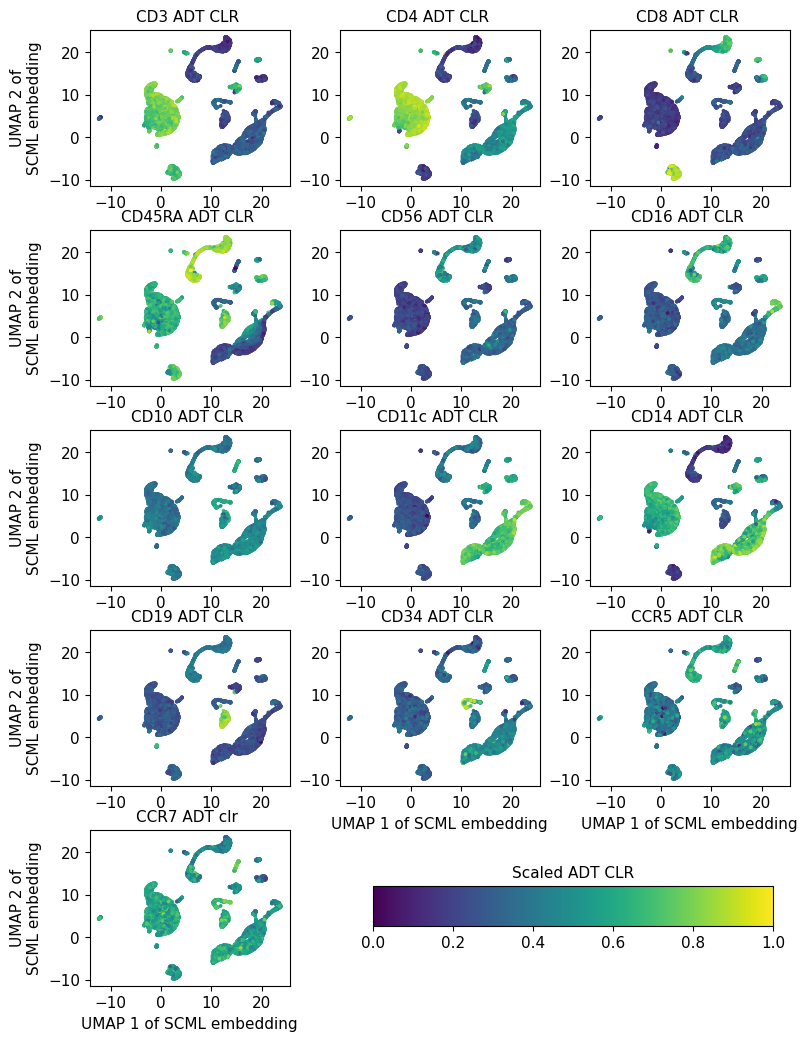

In [25]:
fig = plt.figure(figsize=(8.5, 11))
width = (1 / 3) * (1 - (1 / 8.5))
height = (1 / 5) * (10 / 11)
margin = 1 / 17
for i in range(4):
    for j in range(3):
        ab = cbmc_adt_clr.columns[3*i + j]
        
        adt_clr_scaled = (cbmc_adt_clr.loc[:, ab] - cbmc_adt_clr.loc[:, ab].min()) 
        adt_clr_scaled /= adt_clr_scaled.max()
        
        ax = fig.add_axes([(0.5 / 8.5) + j * width,
                           1 - (0.5 / 11.) - (i + 1) * height,
                           0.8 * width, 0.78 * height])
        
        sc = ax.scatter(embedding[:, 0], embedding[:, 1],
                               c=adt_clr_scaled, s=3)
        
        if(j == 0):
            ax.set_ylabel("UMAP 2 of\nSCML embedding", fontsize=11)
        if(i == 3 and j > 0):
            ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
        
        ax.set_title("{} ADT CLR ".format(ab), fontsize=11)
        
        
ax = fig.add_axes([(0.5 / 8.5), (0.5 / 11.), 0.8 * width, 0.78 * height])
ab = "CCR7"
adt_clr_scaled = (cbmc_adt_clr.loc[:, ab] - cbmc_adt_clr.loc[:, ab].min()) 
adt_clr_scaled /= adt_clr_scaled.max()
        
sc = ax.scatter(embedding[:, 0], embedding[:, 1],
                       c=adt_clr_scaled, s = 3, vmin = 0.0, vmax = 1.0)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of\nSCML embedding", fontsize=11)
ax.set_title("{} ADT clr ".format(ab), fontsize=11)

cbar_ax = fig.add_axes([(2/3)*(16/17) - 0.8 * width, 0.1, 1.6 * width, 0.2 * height])
cbar_ax.set_title("Scaled ADT CLR", fontsize=11)
plt.colorbar(sc, cbar_ax, orientation="horizontal")

plt.savefig("../../sc-spectrum-figures/supplemental-figure-adt-scatter-dist.pdf", format="pdf",
            transparent=True, bbox_inches="tight")

### Seurat WNN with different resolution values

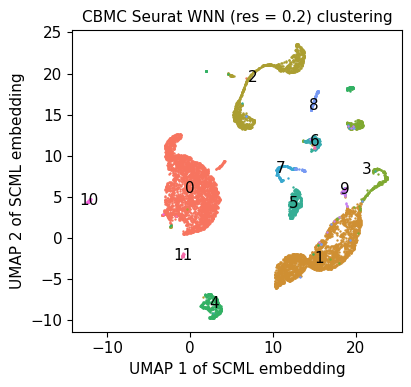

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             seurat_meta.loc[human_cells]["wsnn_res.0.2"], legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC Seurat WNN (res = 0.2) clustering", fontsize=11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-seurat-wnn-res-0.2.pdf", format="pdf", transparent=True)

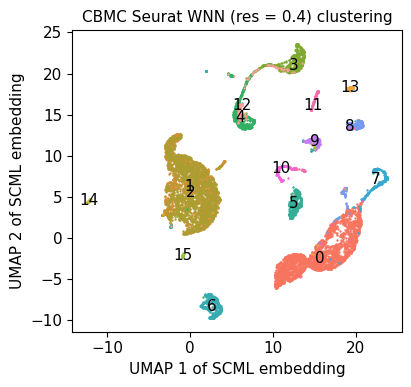

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             seurat_meta.loc[human_cells]["wsnn_res.0.4"], legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC Seurat WNN (res = 0.4) clustering", fontsize=11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-seurat-wnn-res-0.4.pdf", format="pdf", transparent=True)

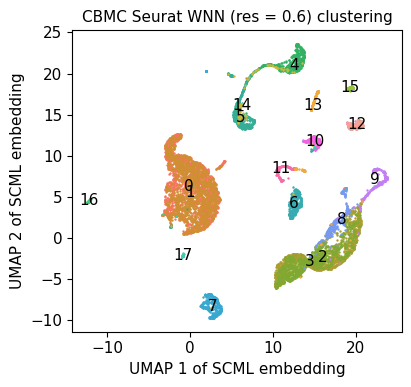

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             seurat_meta.loc[human_cells]["wsnn_res.0.6"], legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC Seurat WNN (res = 0.6) clustering", fontsize=11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-seurat-wnn-res-0.6.pdf", format="pdf", transparent=True)

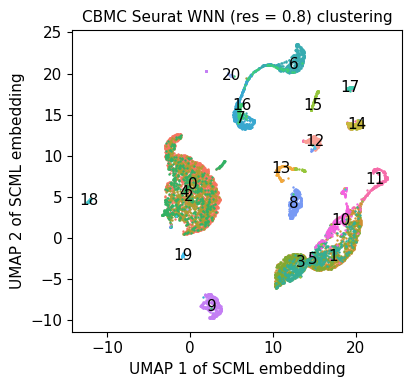

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             seurat_meta.loc[human_cells]["wsnn_res.0.8"], legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC Seurat WNN (res = 0.8) clustering", fontsize=11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-seurat-wnn-res-0.8.pdf", format="pdf", transparent=True)

### Compare ADT CLR distribution for clusters of interest

In [30]:
df_adt_clr_cls = cbmc_adt_clr.copy()
df_adt_clr_cls["scml_cls"] = cbmc_scml_cls
df_adt_clr_cls["library"] = cbmc_adt_count.sum(axis=0)

<AxesSubplot:xlabel='scml_cls', ylabel='CD8'>

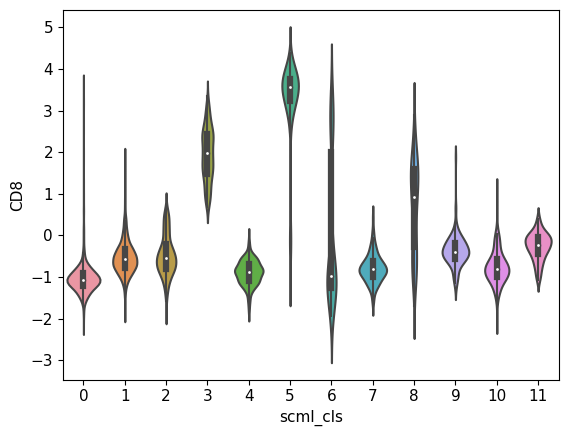

In [31]:
sns.violinplot(x = "scml_cls", y="CD8", data = df_adt_clr_cls)

<AxesSubplot:xlabel='scml_cls', ylabel='CD45RA'>

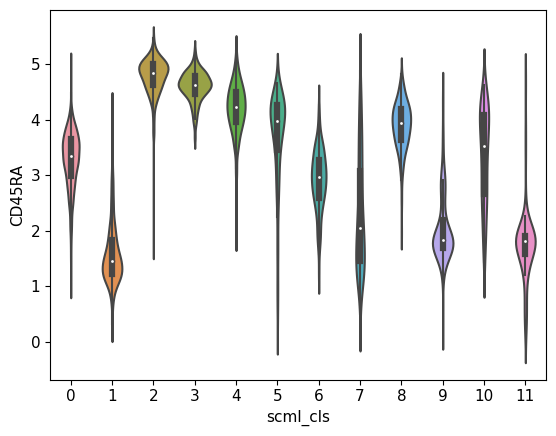

In [32]:
sns.violinplot(x = "scml_cls", y="CD45RA", data = df_adt_clr_cls)

Text(0, 0.5, 'ADT library size')

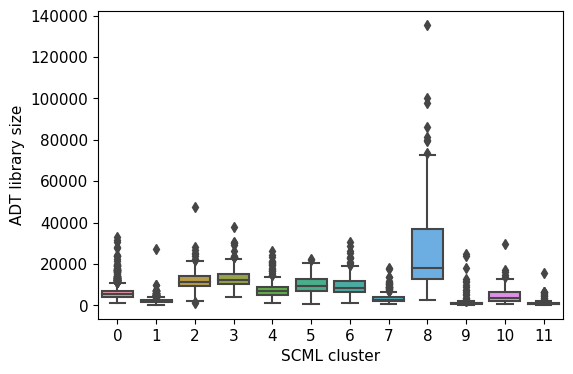

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

bp = sns.boxplot(x = "scml_cls", y="library", data = df_adt_clr_cls)

bp.set_xlabel("SCML cluster", fontsize=11)
bp.set_ylabel("ADT library size", fontsize=11)


In [34]:
print(df_adt_clr_cls[df_adt_clr_cls["scml_cls"] == 7]["library"].median(),
      df_adt_clr_cls[df_adt_clr_cls["scml_cls"] == 8]["library"].median())

2735.0 18008.0


In [35]:
df_rna_pca_cls = cbmc_rna_hm_pca.copy()
df_rna_pca_cls["scml_cls"] = cbmc_scml_cls
df_rna_pca_cls["library"] = cbmc_rna_count.loc[:, human_cells].sum(axis = 0)

Text(0, 0.5, 'RNA library size')

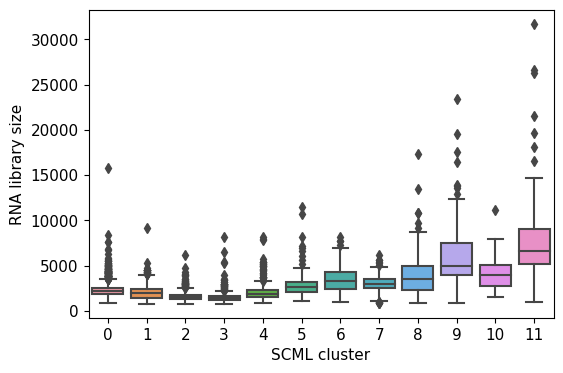

In [36]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
bp = sns.boxplot(x = "scml_cls", y="library", data = df_rna_pca_cls)

bp.set_xlabel("SCML cluster", fontsize=11)
bp.set_ylabel("RNA library size", fontsize=11)

In [37]:
print(df_rna_pca_cls[df_rna_pca_cls["scml_cls"] == 7]["library"].median(),
      df_rna_pca_cls[df_rna_pca_cls["scml_cls"] == 8]["library"].median())

2968.0 3570.5


### Merge T cell clusters and recompute the silhouette score

In [38]:
# Merge CD4+ and CD8+ from SCML
cl_merged = cbmc_scml_cls.copy()
cl_merged[np.where(cl_merged == 5)[0]] = 0

cl_seurat_merged = seurat_meta["wsnn_res.0.2"].values.copy()
cl_seurat_merged[np.where(cl_seurat_merged == 4)] = 0

print("Full RNA Euclidean SCML T cell = {}".format(silhouette_score(D_rna, cl_merged, metric = "precomputed")))
print("Full ADT Euclidean SCML T cell = {}".format(silhouette_score(D_adt, cl_merged, metric = "precomputed")))

print("Full RNA Euclidean Seurat WNN = {}".format(silhouette_score(D_rna, cl_seurat_merged, metric = "precomputed")))
print("Full ADT Euclidean Seurat WNN = {}".format(silhouette_score(D_adt, cl_seurat_merged, metric = "precomputed")))

Full RNA Euclidean SCML T cell = 0.33028248667136445
Full ADT Euclidean SCML T cell = 0.3486636384682415
Full RNA Euclidean Seurat WNN = 0.2788985351448795
Full ADT Euclidean Seurat WNN = 0.2998884984877587


In [39]:
seurat_meta.shape

(8005, 30)

In [40]:
# Merge CD8+ and CD8- NK cells from SCML
cl_merged = cbmc_scml_cls.copy()
cl_merged[np.where(cl_merged == 3)[0]] = 2

cl_seurat_merged = seurat_meta["wsnn_res.0.2"].values.copy()
cl_seurat_merged[np.where(cl_seurat_merged == 4)] = 4

print("Full RNA Euclidean SCML T cell = {}".format(silhouette_score(D_rna, cl_merged, metric = "precomputed")))
print("Full ADT Euclidean SCML T cell = {}".format(silhouette_score(D_adt, cl_merged, metric = "precomputed")))

print("Full RNA Euclidean Seurat WNN = {}".format(silhouette_score(D_rna, cl_seurat_merged, metric = "precomputed")))
print("Full ADT Euclidean Seurat WNN = {}".format(silhouette_score(D_adt, cl_seurat_merged, metric = "precomputed")))

Full RNA Euclidean SCML T cell = 0.2757814660071386
Full ADT Euclidean SCML T cell = 0.416286471483748
Full RNA Euclidean Seurat WNN = 0.24065752804118104
Full ADT Euclidean Seurat WNN = 0.3977267723355348


### Hyperparameter alpha grid search

In [41]:
scml_cluster_labels_250 = []

scml_silhouettes_250 = np.zeros((50, 2))
for i in range(50):
    if(i % 10 == 0):
        print(i)
    w_scml_a, v_scml_a, scml_cls_a = scml([Gs_rna, Gs_adt], n_clust=n_clust, device=device, alpha=5. * i)
    scml_cluster_labels_250.append(scml_cls_a)
    scml_silhouettes_250[i, 0] = silhouette_score(D_rna, scml_cls_a, metric = "precomputed")
    scml_silhouettes_250[i, 1] = silhouette_score(D_adt, scml_cls_a, metric = "precomputed")    

0
10
20
30
40


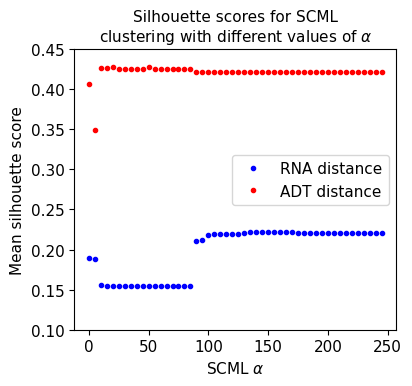

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (4.25, 4))

l1, = plt.plot([5. * i for i in range(50)], scml_silhouettes_250[:, 0], 'b.')
l2, = plt.plot([5. * i for i in range(50)], scml_silhouettes_250[:, 1], 'r.')

ax.legend(handles = [l1, l2], labels = ["RNA distance", "ADT distance"],
          loc = "upper right", bbox_to_anchor = [0., -0.35, 1.0, 1.0])

ax.set_xlabel(r"SCML $\alpha$", fontsize = 11)
ax.set_ylabel("Mean silhouette score", fontsize = 11)

ax.set_title("Silhouette scores for SCML\nclustering with different values of " + r"$\alpha$", fontsize = 11) 

ax.set_ylim([0.1, 0.45])

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-scml-alpha-range-250.pdf", format="pdf", transparent=True, bbox_inches="tight")

In [43]:
nmi_alpha_250 = np.zeros((50, 50))
for i in range(50):
    for j in range(50):
        nmi_alpha_250[i, j] = normalized_mutual_info_score(scml_cluster_labels_250[i],
                                                           scml_cluster_labels_250[j])

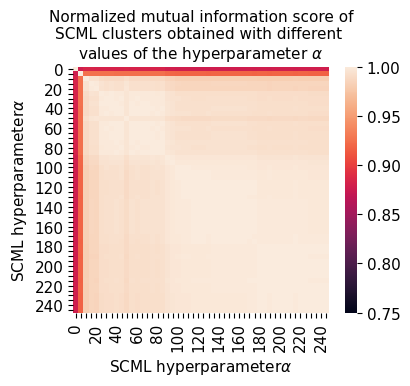

In [44]:
fig = plt.figure(figsize=(4.25, 4))

ax = sns.heatmap(nmi_alpha_250, vmin = 0.75, vmax = 1.0,
                 xticklabels=list(range(0,250,5)),
                 yticklabels=list(range(0,250,5)))

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
ax.set_xlabel("SCML hyperparameter" + r"$\alpha$", fontsize = 11)
ax.set_ylabel("SCML hyperparameter" + r"$\alpha$", fontsize = 11)

ax.set_title("Normalized mutual information score of\n" +
             "SCML clusters obtained with different \n" +
             "values of the hyperparameter " + r"$\alpha$",
             fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-scml-alpha-nmi-250.pdf", format="pdf", transparent=True, bbox_inches="tight")

In [45]:
scml_cluster_labels_10 = []

scml_silhouettes_10 = np.zeros((100, 2))
for i in range(100):
    if(i % 10 == 0):
        print(i)
    w_scml_a, v_scml_a, scml_cls_a = scml([Gs_rna, Gs_adt], n_clust=n_clust, device=device, alpha=0.1 * i)
    scml_cluster_labels_10.append(scml_cls_a)
    scml_silhouettes_10[i, 0] = silhouette_score(D_rna, scml_cls_a, metric = "precomputed")
    scml_silhouettes_10[i, 1] = silhouette_score(D_adt, scml_cls_a, metric = "precomputed")
    

0
10
20
30
40
50
60
70
80
90


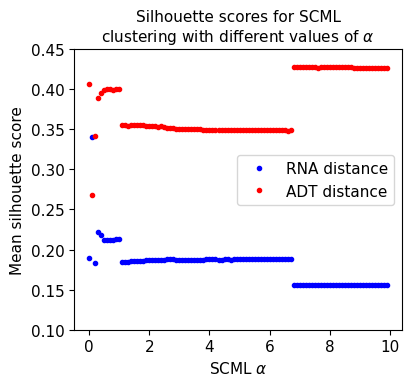

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (4.25, 4))

l1, = plt.plot([0.1 * i for i in range(100)], scml_silhouettes_10[:, 0], 'b.')
l2, = plt.plot([0.1 * i for i in range(100)], scml_silhouettes_10[:, 1], 'r.')

ax.legend(handles = [l1, l2], labels = ["RNA distance", "ADT distance"],
          loc = "upper right", bbox_to_anchor = [0., -0.35, 1.0, 1.0])

ax.set_xlabel(r"SCML $\alpha$", fontsize = 11)
ax.set_ylabel("Mean silhouette score", fontsize = 11)

ax.set_title("Silhouette scores for SCML\nclustering with different values of " + r"$\alpha$", fontsize = 11) 

ax.set_ylim([0.1, 0.45])

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-scml-alpha-range-10.pdf", format="pdf", transparent=True, bbox_inches="tight")

In [47]:
nmi_alpha_10 = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        nmi_alpha_10[i, j] = normalized_mutual_info_score(scml_cluster_labels_10[i],
                                                          scml_cluster_labels_10[j])

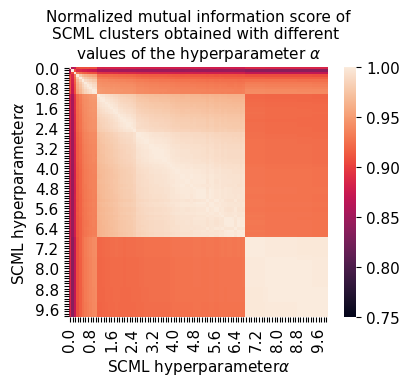

In [48]:
fig = plt.figure(figsize=(4.25, 4))

ax = sns.heatmap(nmi_alpha_10, vmin = 0.75, vmax = 1.0,
                 xticklabels=[x / 10. for x in list(range(0, 100, 1))],
                 yticklabels=[x / 10. for x in list(range(0, 100, 1))])

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
for label in ax.xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
    
ax.set_xlabel("SCML hyperparameter" + r"$\alpha$", fontsize = 11)
ax.set_ylabel("SCML hyperparameter" + r"$\alpha$", fontsize = 11)

ax.set_title("Normalized mutual information score of\n" +
             "SCML clusters obtained with different \n" +
             "values of the hyperparameter " + r"$\alpha$",
             fontsize = 11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-scml-alpha-nmi-10.pdf", format="pdf", transparent=True, bbox_inches="tight")

In [48]:
print(np.max(scml_silhouettes_250[:, 0]),
      np.max(scml_silhouettes_250[:, 1]))

0.22133470821204904 0.42728707402335175


In [49]:
print(np.argmax(scml_silhouettes_250[:, 0]),
      np.argmax(scml_silhouettes_250[:, 1]))

print(np.argmax(scml_silhouettes_250[:, 0]) * 5.0,
      np.argmax(scml_silhouettes_250[:, 1]) * 5.0)

34 4
170.0 20.0


In [50]:
print(np.max(scml_silhouettes_10[:, 0]),
      np.max(scml_silhouettes_10[:, 1]))

0.34079326770058976 0.42737205670578804


In [51]:
print(np.argmax(scml_silhouettes_10[:, 0]),
      np.argmax(scml_silhouettes_10[:, 1]))

print(np.argmax(scml_silhouettes_10[:, 0]) * 0.1,
      np.argmax(scml_silhouettes_10[:, 1]) * 0.1)

1 75
0.1 7.5


### SCML clustering with alpha = 1

In [52]:
print("Start: {}".format(asctime(localtime())))
w_scml_1, v_scml_1, cbmc_scml_1_cls = scml([Gs_rna, Gs_adt], n_clust=n_clust, device=device, alpha=1.0)
print("End: {}".format(asctime(localtime())))

Start: Mon Apr 11 11:57:06 2022
End: Mon Apr 11 11:57:17 2022


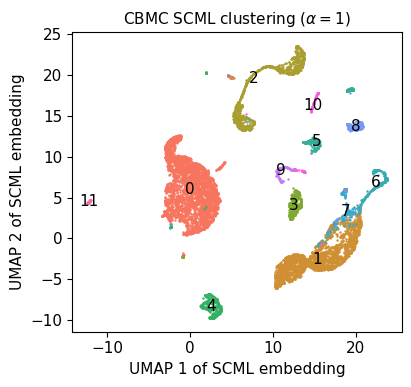

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4))

umap_scatter(ax, pd.DataFrame(embedding, index=cbmc_adt_clr.index, columns=["UMAP 1", "UMAP 2"]),
             cbmc_scml_1_cls, legend = False)

ax.set_xlabel("UMAP 1 of SCML embedding", fontsize=11)
ax.set_ylabel("UMAP 2 of SCML embedding", fontsize=11)
ax.set_title("CBMC SCML clustering " + r"($\alpha = 1$)", fontsize=11)

plt.tight_layout()
plt.savefig("../../sc-spectrum-figures/supplemental-figure-scml-1.pdf", format="pdf", transparent=True)

In [54]:
print("Full RNA Euclidean SCML = {}".format(silhouette_score(D_rna, cbmc_scml_cls, metric = "precomputed")))
print("Full ADT Euclidean SCML = {}".format(silhouette_score(D_adt, cbmc_scml_cls, metric = "precomputed")))

print("Full RNA Euclidean Seurat WNN = {}".format(silhouette_score(D_rna, seurat_meta["wsnn_res.0.2"][human_cells], metric = "precomputed")))
print("Full ADT Euclidean Seurat WNN = {}".format(silhouette_score(D_adt, seurat_meta["wsnn_res.0.2"][human_cells], metric = "precomputed")))

Full RNA Euclidean SCML = 0.2177251733523114
Full ADT Euclidean SCML = 0.4211400956285408
Full RNA Euclidean Seurat WNN = 0.24065752804118104
Full ADT Euclidean Seurat WNN = 0.3977267723355348


## Subsample graph visual

In [55]:
np.random.seed(12345678)
n_down = 100
down_ind = np.random.permutation(cbmc_rna_hm_pca.shape[0])[:n_down]-1
down_ind.sort()

cbmc_rna_pca_subset = cbmc_rna_hm_pca.iloc[down_ind, :]
cbmc_adt_clr_subset = cbmc_adt_clr.iloc[down_ind, :]

In [56]:
down_ind

array([  76,  220,  283,  296,  324,  423,  444,  515,  664,  682,  776,
        813,  835,  836,  866,  986,  996, 1034, 1114, 1246, 1362, 1456,
       1475, 1553, 1626, 1652, 1768, 1799, 1832, 1872, 1931, 1967, 2099,
       2159, 2180, 2219, 2239, 2514, 2519, 2571, 2595, 2752, 2784, 2993,
       3102, 3281, 3435, 3491, 3542, 3686, 3701, 3739, 3886, 3980, 4038,
       4156, 4183, 4287, 4311, 4414, 4453, 4473, 4701, 4722, 4870, 4894,
       4975, 5048, 5114, 5226, 5243, 5295, 5484, 5512, 5717, 5752, 5762,
       5763, 6156, 6160, 6353, 6489, 6507, 6532, 6609, 6613, 6651, 6674,
       7153, 7270, 7369, 7384, 7417, 7524, 7667, 7705, 7709, 7917, 7924,
       7947])

In [57]:
Gs_rna_subset = rbf_neighbor_graph(cbmc_rna_pca_subset.values.astype(np.float32), adaptive = True, k = 5, a = 5)
Gs_adt_subset = rbf_neighbor_graph(cbmc_adt_clr_subset.values.astype(np.float32), adaptive = True, k = 5, a = 5)

In [58]:
pd.DataFrame(Gs_rna_subset.toarray(),
             index = cbmc_rna_pca_subset.index,
             columns = cbmc_rna_pca_subset.index).to_csv("../../sc-spectrum-datasets/Gs_rna_cbmc_subset100.csv")

pd.DataFrame(Gs_adt_subset.toarray(),
             index = cbmc_adt_clr_subset.index,
             columns = cbmc_adt_clr_subset.index).to_csv("../../sc-spectrum-datasets/Gs_adt_cbmc_subset100.csv")